In [26]:
# SU(2) Quantum Link Model via SO(5), 14-dimensional link space
# --------------------------------------------------------------
# Constructs explicit L_a, R_a, and U_i (i=1..4) operators in the 14-dim irrep,
# and verifies all commutation relations.

import numpy as np

# ---------- small utilities ----------

def comm(A, B):
    return A @ B - B @ A

def levi_civita_3():
    eps = np.zeros((3,3,3), dtype=int)
    eps[0,1,2] = eps[1,2,0] = eps[2,0,1] = 1
    eps[2,1,0] = eps[1,0,2] = eps[0,2,1] = -1
    return eps

# ---------- so(5) generators in 5-vector (fundamental) rep ----------

def so5_gen_hermitian(A, B, N=5):
    """
    Hermitian generators H_{AB} with A<B in {1..N}:
    H_{AB} = i (E_{AB} - E_{BA})
    They satisfy [H_{AB}, H_{CD}] = i(δ_{BC}H_{AD} - δ_{AC}H_{BD} - δ_{BD}H_{AC} + δ_{AD}H_{BC}).
    """
    A -= 1; B -= 1
    E = np.zeros((N,N), dtype=complex)
    E[A,B] = 1.0
    E[B,A] = -1.0
    return 1j * E

N = 5
H5 = {}
for A in range(1, N+1):
    for B in range(A+1, N+1):
        H5[(A,B)] = so5_gen_hermitian(A, B, N)

# ---------- build the 14-dim symmetric traceless irrep from the 5-vector ----------

def symmetric_basis_5x5():
    """
    Orthonormal basis of Sym^2(R^5) as 25-vectors (flattened 5x5).
    For i<j: (|ij> + |ji>)/sqrt(2).  For i=j: |ii>.
    Returns:
      Q15 : (25 x 15) with columns = basis vectors,
      idx : list of (i,j) (0-based) for each column.
    """
    cols = []
    idx = []
    e = np.eye(5)
    for i in range(5):
        # diagonal
        M = np.zeros((5,5))
        M[i,i] = 1.0
        cols.append(M.reshape(-1))
        idx.append((i,i))
        # off-diagonal
        for j in range(i+1,5):
            M = np.zeros((5,5))
            M[i,j] = M[j,i] = 1/np.sqrt(2)
            cols.append(M.reshape(-1))
            idx.append((i,j))
    Q15 = np.stack(cols, axis=1).astype(complex)
    return Q15, idx

Q15, idx15 = symmetric_basis_5x5()

# "Trace" vector in Sym^2 is proportional to sum_i |ii>
trace_vec = np.zeros((25,1), dtype=complex)
for col,(i,j) in enumerate(idx15):
    if i==j: trace_vec[:,0] += Q15[:,col]
trace_vec /= np.linalg.norm(trace_vec)

# Build a convenient 14-dim orthonormal basis by projecting out the trace
# Start from 15 symmetric basis vectors, project each to traceless subspace, then QR.
Proj_traceless = np.eye(25, dtype=complex) - trace_vec @ trace_vec.conj().T
W = Proj_traceless @ Q15                                # 25 x 15, columns in traceless subspace
# Drop one (linearly dependent) column and orthonormalize the remaining 14 columns
W14_raw = W[:, :-1]                                     # 25 x 14 (span is already traceless)
Q14, _ = np.linalg.qr(W14_raw)                          # 25 x 14 with orthonormal columns

def lift_to_14(T5):
    """
    Given a 5x5 Hermitian matrix T5 acting on the vector rep,
    return its action on Sym^2_traceless via T = Q14^† (T⊗I + I⊗T) Q14.
    """
    I5 = np.eye(5, dtype=complex)
    K = np.kron(T5, I5) + np.kron(I5, T5)               # 25 x 25
    return Q14.conj().T @ K @ Q14                       # 14 x 14, Hermitian

# Lift all so(5) generators to the 14-rep
H14 = { key: lift_to_14(mat) for key, mat in H5.items() }

# ---------- 't Hooft symbols to split so(4) ≅ su(2)_L ⊕ su(2)_R ----------

def tHooft_symbols():
    """
    eta^a_{ij}, bar_eta^a_{ij} for i,j = 1..4 (we store 0..3),
    with the standard conventions:
      eta^a_{ij} = ε_{aij}  (i,j <= 3),
      eta^a_{i4} =  δ_{ai}, eta^a_{4i} = -δ_{ai};
      bar_eta^a_{ij} = ε_{aij} (i,j <= 3),
      bar_eta^a_{i4} = -δ_{ai}, bar_eta^a_{4i} =  δ_{ai}.
    """
    eta = np.zeros((3,4,4), dtype=int)
    bar = np.zeros((3,4,4), dtype=int)
    eps = levi_civita_3()
    for a in range(3):
        for i in range(3):
            for j in range(3):
                eta[a,i,j] = eps[a,i,j]
                bar[a,i,j] = eps[a,i,j]
    for a in range(3):
        for i in range(3):
            eta[a,i,3]  =  1 if a==i else 0
            eta[a,3,i]  = -1 if a==i else 0
            bar[a,i,3]  = -1 if a==i else 0
            bar[a,3,i]  =  1 if a==i else 0
    return eta, bar

eta, bar_eta = tHooft_symbols()

# ---------- L_a, R_a and U_i in the 14-rep ----------

# First define the so(4) part H_{ij} (i,j=1..4) and the "vector" components H_{i5}, then combine.
# IMPORTANT: with our Hermitian normalization, the correct SU(2) normalization for L,R is:
#   L_a = -(1/2) * sum_{1<=i<j<=4} eta^a_{ij} H_{ij}
#   R_a = -(1/2) * sum_{1<=i<j<=4} bar_eta^a_{ij} H_{ij}
# and U_i := H_{i5}  (i=1..4)

def build_LR_U_in_14():
    L = []
    R = []
    for a in range(3):
        LA = np.zeros((14,14), dtype=complex)
        RA = np.zeros((14,14), dtype=complex)
        for i in range(4):
            for j in range(i+1,4):
                LA += -0.5 * eta[a,i,j]     * H14[(i+1, j+1)]
                RA += -0.5 * bar_eta[a,i,j] * H14[(i+1, j+1)]
        L.append(LA)
        R.append(RA)
    # U components (the four "bifundamentals" of so(4))
    U = [ H14[(i+1, 5)] for i in range(4) ]
    return L, R, U

L, R, U = build_LR_U_in_14()

# Optional: pack the four U_i into a 2x2 operator-valued matrix (quaternionic packaging).
# This is just a convenient view; the tested commutators below are done component-wise on U_i.
def U_as_2x2_blocks(U):
    U1, U2, U3, U4 = U
    U11 = U4 + U3
    U12 = U1 - 1j*U2
    U21 = U1 + 1j*U2
    U22 = U4 - U3
    return np.array([[U11, U12],
                     [U21, U22]], dtype=object)

U_blocks = U_as_2x2_blocks(U)  # not used in tests, but handy to have

# ---------- Test suite: verify all commutation relations ----------

eps = levi_civita_3()

def max_norm(X):
    return np.max(np.abs(X))

def check_su2(X, name="X", tol=1e-12, verbose=True):
    ok = True
    for a in range(3):
        for b in range(3):
            lhs = comm(X[a], X[b])
            rhs = 1j * sum(eps[a,b,c] * X[c] for c in range(3))
            err = np.linalg.norm(lhs - rhs)
            if err > tol:
                ok = False
                if verbose:
                    print(f"[{name}] su(2) fail for ({a},{b}), ||Δ||={err:.3e}")
    if verbose and ok:
        print(f"[{name}] su(2) passed with tol={tol}.")
    return ok

def check_commutes(A, B, tol=1e-12, verbose=True):
    ok = True
    for a in range(3):
        for b in range(3):
            err = np.linalg.norm(comm(A[a], B[b]))
            if err > tol:
                ok = False
                if verbose:
                    print(f"[A,B] commute fail at (a={a}, b={b}), ||[A,B]||={err:.3e}")
    if verbose and ok:
        print("[A,B] commute test passed.")
    return ok

def check_U_transform(L_or_R, U, symbol, tol=1e-12, verbose=True):
    """
    Checks:
      [L_a, U_i] = i/2 * eta^a_{ij} U_j     if symbol='eta'
      [R_a, U_i] = i/2 * bar_eta^a_{ij} U_j if symbol='bar'
    """
    ok = True
    table = eta if symbol=='eta' else bar_eta
    for a in range(3):
        for i in range(4):
            lhs = comm(L_or_R[a], U[i])
            rhs = 1j * 0.5 * sum(table[a,i,j] * U[j] for j in range(4))
            err = np.linalg.norm(lhs - rhs)
            if err > tol:
                ok = False
                if verbose:
                    name = "L" if symbol=='eta' else "R"
                    print(f"[{name},U] fail at (a={a}, i={i}), ||Δ||={err:.3e}")
    if verbose and ok:
        print(f"[{('L' if symbol=='eta' else 'R')},U] transform test passed.")
    return ok

def reconstruct_Hij_from_LR(i, j):
    """
    Using H_{ij} = - (eta^a_{ij} L_a + bar_eta^a_{ij} R_a) with our normalization.
    (i,j are 0-based in {0,1,2,3} ≡ {1..4})
    """
    return - sum( eta[a,i,j] * L[a] + bar_eta[a,i,j] * R[a] for a in range(3) )

def check_UU_closure(U, tol=1e-12, verbose=True):
    """
    Checks [U_i, U_j] = -i H_{ij} = i(eta^a_{ij} L_a + bar_eta^a_{ij} R_a)
    for 1 <= i < j <= 4 (0-based here).
    """
    ok = True
    for i in range(4):
        for j in range(i+1,4):
            lhs = comm(U[i], U[j])
            Hij = reconstruct_Hij_from_LR(i, j)   # H_{ij} = - (η L + \barη R)
            rhs = -1j * Hij                       # <-- sign fix here
            err = np.linalg.norm(lhs - rhs)
            if err > tol:
                ok = False
                if verbose:
                    print(f"[U_i,U_j] fail at (i={i}, j={j}), ||Δ||={err:.3e}")
    if verbose and ok:
        print("[U_i,U_j] closure test passed.")
    return ok


# ---- Run all tests (prints a short report) ----
_ = check_su2(L, name="L")
_ = check_su2(R, name="R")
_ = check_commutes(L, R)
_ = check_U_transform(L, U, symbol='eta')
_ = check_U_transform(R, U, symbol='bar')
_ = check_UU_closure(U)

# At this point you have:
#   L[0], L[1], L[2]  (14x14 Hermitian)
#   R[0], R[1], R[2]  (14x14 Hermitian)
#   U[0], U[1], U[2], U[3]  (14x14 Hermitian)
# and (optionally) a 2x2 "packaging" U_blocks = [[..,..],[..,..]] with operator blocks.


[L] su(2) passed with tol=1e-12.
[R] su(2) passed with tol=1e-12.
[A,B] commute test passed.
[L,U] transform test passed.
[R,U] transform test passed.
[U_i,U_j] closure test passed.


In [27]:
import scipy as sc
import scipy.sparse as scs

In [28]:
U00 = U[3] + U[2]
U01 = U[0] - 1j*U[1]
U10 = U[0] + 1j*U[1]
U11 = U[3] - U[2]

In [29]:
U = [[sc.sparse.coo_matrix(np.matrix(U00)),sc.sparse.coo_matrix(np.matrix(U01))],[sc.sparse.coo_matrix(np.matrix(U10)),sc.sparse.coo_matrix(np.matrix(U11))]]

U_dag = [[sc.sparse.coo_matrix(np.matrix(U00).H),sc.sparse.coo_matrix(np.matrix(U10).H)],[sc.sparse.coo_matrix(np.matrix(U01).H),sc.sparse.coo_matrix(np.matrix(U11).H)]]

In [30]:
res_00 = 0
res_11 = 0

for k1 in [0,1]:
    for k2 in [0,1]:
        for k3 in [0,1]:
            res_00 += scs.kron(scs.kron(scs.kron(U[0][k1],U[k1][k2]),U_dag[k2][k3]),U_dag[k3][0])
            res_11 += scs.kron(scs.kron(scs.kron(U[1][k1],U[k1][k2]),U_dag[k2][k3]),U_dag[k3][1])

In [31]:
H_mag = res_00 + res_11 + (res_11+  res_00).conjugate().transpose()

In [32]:
mat_el = scs.coo_matrix(np.matrix(L[1]@L[1]+L[2]@L[2]+L[0]@L[0]+R[1]@R[1]+R[2]@R[2]+R[0]@R[0]))

In [33]:
id = scs.coo_matrix(np.identity(14))

In [34]:
H_el = scs.kron(scs.kron(scs.kron(mat_el,id),id),id)
H_el += scs.kron(scs.kron(scs.kron(id,mat_el),id),id)
H_el += scs.kron(scs.kron(scs.kron(id,id),mat_el),id)
H_el += scs.kron(scs.kron(scs.kron(id,id),id),mat_el)

In [46]:
vals = []
g2 = np.linspace(0.1,10,50)
for i in g2:
    vals.append(sc.sparse.linalg.eigsh(i*H_el+1/i*H_mag, which="SA", k=6)[0])
    #vals.append(np.linalg.eigvalsh(i*H_el+1/i*H_mag))
    print(i)

vals = np.array(vals)

0.1
0.3020408163265306
0.5040816326530613
0.7061224489795919
0.9081632653061225
1.1102040816326533
1.3122448979591839
1.5142857142857145
1.716326530612245
1.9183673469387756
2.1204081632653065
2.322448979591837
2.5244897959183676
2.7265306122448982
2.928571428571429
3.1306122448979594
3.33265306122449
3.5346938775510206
3.736734693877551
3.938775510204082
4.140816326530612
4.3428571428571425
4.544897959183674
4.746938775510204
4.948979591836735
5.151020408163265
5.353061224489796
5.555102040816326
5.757142857142857
5.959183673469387
6.161224489795918
6.3632653061224485
6.5653061224489795
6.7673469387755105
6.969387755102041
7.171428571428572
7.373469387755102
7.575510204081633
7.777551020408163
7.979591836734694
8.181632653061225
8.383673469387755
8.585714285714285
8.787755102040816
8.989795918367347
9.191836734693878
9.393877551020408
9.595918367346938
9.79795918367347
10.0


In [47]:
import plaqTheory as p
p1x1 = np.empty((50,4))
for i in range(50):
    p1x1[i] = p.getGroundState(4/(g2[i]))

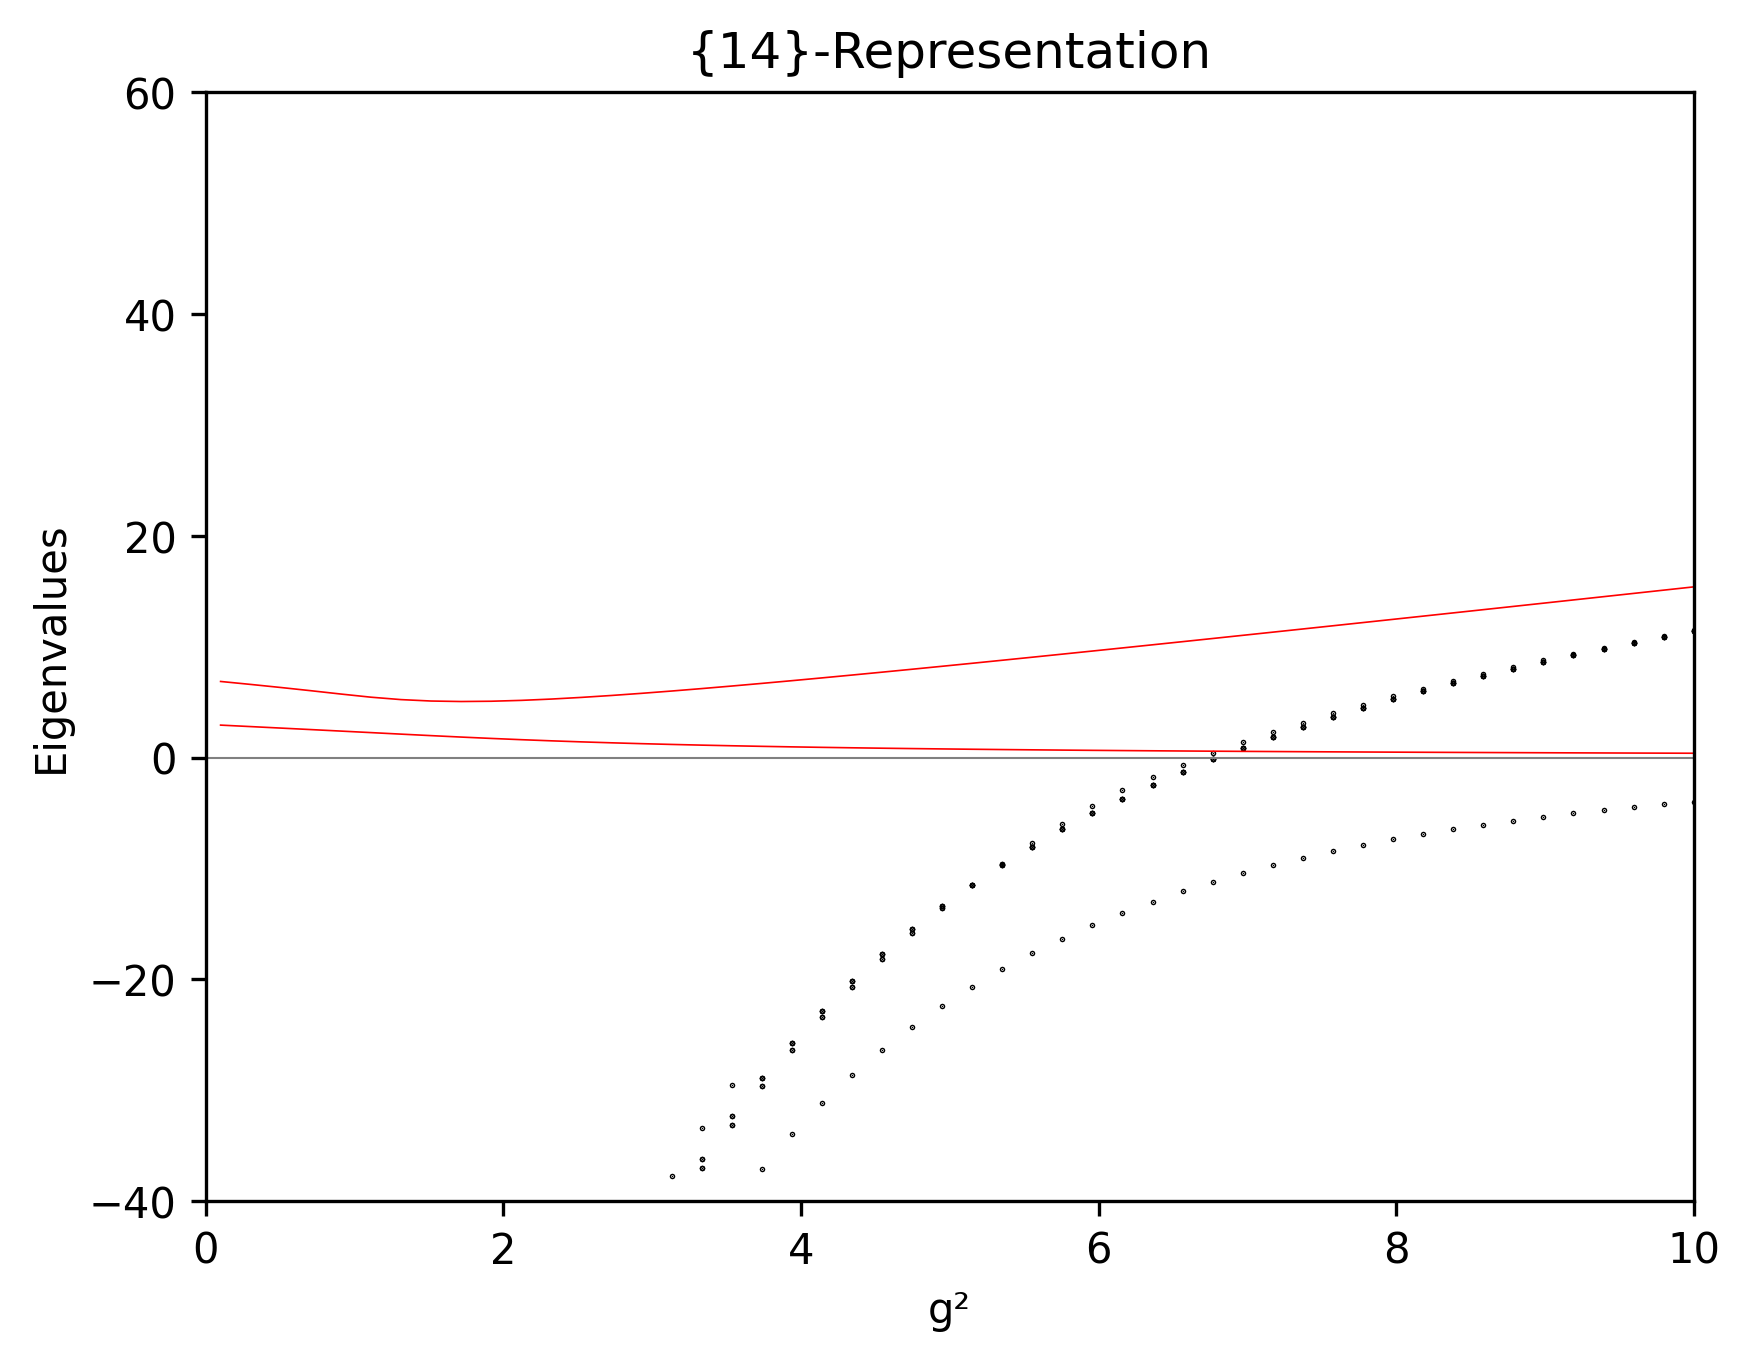

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#fig.set_size_inches(12, 8)
fig.set_dpi(300)

for i in range(6):
    plt.scatter(g2, vals[:,i], color="black",s=0.11)#, linewidth="0.2")

plt.plot(g2,p1x1[:,0], color="red", linewidth="0.4")
plt.plot(g2,p1x1[:,0]+p1x1[:,2], color="red", linewidth="0.4")

#plt.hlines([2,-2], xmax=1, xmin=0, colors="black",linewidth=0.5)
plt.hlines(y=0,xmin=0,xmax=25, color="grey",linewidth=0.5)
plt.xlabel("g²")
plt.ylabel("Eigenvalues")
#plt.yscale("symlog")
plt.title("{14}-Representation")

plt.ylim(-40,60)
plt.xlim(0,10)

plt.savefig("plot_14rep.pdf", dpi=300)